In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from darts import TimeSeries
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
data_path = 'db.csv'

In [3]:
df = pd.read_csv(f'{data_path}', sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64765 entries, 0 to 64764
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Billing date       64765 non-null  int64 
 1   Material           64765 non-null  int64 
 2   Phisical quantity  64765 non-null  int64 
 3   Country            64765 non-null  int64 
 4   Net price          64765 non-null  object
dtypes: int64(4), object(1)
memory usage: 2.5+ MB


In [4]:
df.head(10)

,Billing date,Material,Phisical quantity,Country,Net price
0,10052022,1795,10,7511,"2,865"
1,10052022,1778,5,7511,"0,66375"
2,10052022,1778,15,7511,"0,66375"
3,10052022,9526,4,7511,"36,31125"
4,10052022,1778,11,7511,"0,66375"
5,10052022,1778,15,7511,"0,66375"
6,10052022,1778,5,7511,"0,66375"
7,10052022,2844,2,7511,"35,185"
8,10052022,4151,6,7511,"31,47875"
9,10052022,2844,2,7511,"35,185"


## Preprocesamiento de datos

### Creamos una columna de fecha

In [5]:
def process_date_str(number):
    string = str(number)
    if len(string) == 7:
        string = '0' + string
    return f'{string[4:]}-{string[2:4]}-{string[:2]}'

In [6]:
df['time_str'] = df['Billing date'].apply(process_date_str)
df['time'] = pd.to_datetime(df['time_str'], format='%Y-%m-%d')
df

,Billing date,Material,Phisical quantity,Country,Net price,time_str,time
0,10052022,1795,10,7511,"2,865",2022-05-10,2022-05-10
1,10052022,1778,5,7511,"0,66375",2022-05-10,2022-05-10
2,10052022,1778,15,7511,"0,66375",2022-05-10,2022-05-10
3,10052022,9526,4,7511,"36,31125",2022-05-10,2022-05-10
4,10052022,1778,11,7511,"0,66375",2022-05-10,2022-05-10
...,...,...,...,...,...,...,...
64760,30042024,1634,100,1526,"2,5175",2024-04-30,2024-04-30
64761,30042024,1634,2,1526,"2,5175",2024-04-30,2024-04-30
64762,30042024,1634,60,1526,"2,5175",2024-04-30,2024-04-30
64763,30042024,1679,2,1526,"29,5575",2024-04-30,2024-04-30


## Agrupacion de ventas diarias

In [7]:
first_sale = df['time'].min()
first_sale

Timestamp('2018-08-24 00:00:00')

In [8]:
last_sale = df['time'].max()
last_sale

Timestamp('2024-09-26 00:00:00')

### Agrupación de ventas por ítem

Vemos la cantidad de ventas por ítem

In [9]:
df['Net price'] = df['Net price'].apply(lambda x: x.replace(',', '.')).astype(float)

In [10]:
df.head()

,Billing date,Material,Phisical quantity,Country,Net price,time_str,time
0,10052022,1795,10,7511,2.86500,2022-05-10,2022-05-10
1,10052022,1778,5,7511,0.66375,2022-05-10,2022-05-10
2,10052022,1778,15,7511,0.66375,2022-05-10,2022-05-10
3,10052022,9526,4,7511,36.31125,2022-05-10,2022-05-10
4,10052022,1778,11,7511,0.66375,2022-05-10,2022-05-10


In [11]:
df[(df.Material == 1002)]

,Billing date,Material,Phisical quantity,Country,Net price,time_str,time
6004,7042022,1002,56,1053,0.41375,2022-04-07,2022-04-07
6453,10012023,1002,160,1053,0.32000,2023-01-10,2023-01-10
8655,31082020,1002,224,1053,0.28750,2020-08-31,2020-08-31
8718,29032021,1002,16,1053,0.28750,2021-03-29,2021-03-29
8825,26102021,1002,200,1053,0.42750,2021-10-26,2021-10-26
9560,9022021,1002,40,1053,0.28500,2021-02-09,2021-02-09
9601,23032021,1002,80,1053,0.28500,2021-03-23,2021-03-23
9629,23042021,1002,88,1053,0.28500,2021-04-23,2021-04-23
9637,23042021,1002,112,1053,0.28500,2021-04-23,2021-04-23
11434,25052021,1002,64,9839,0.46000,2021-05-25,2021-05-25


In [12]:
grouped_daily_df = df.groupby(['Material', 'time',]).sum().reset_index()[['time', 'Material', 'Phisical quantity']]
grouped_daily_df = grouped_daily_df.rename(columns={
    'Material': 'item',
    'Phisical quantity': 'sales'
})
grouped_daily_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46230 entries, 0 to 46229
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    46230 non-null  datetime64[ns]
 1   item    46230 non-null  int64         
 2   sales   46230 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


### Rellenamos los periodos de no venta con sales = 0

Se deben rellenar con 0 los periodos faltantes entre la primera y última venta de cada ítem

In [13]:
def fill_no_sales_period(df, item_id):
    item_df = df[df['item'] == item_id]
    existing_dates = item_df['time'].to_list()
    first_sale_date = item_df['time'].min().strftime("%Y-%m-%d")
    last_sale_date = item_df['time'].max().strftime("%Y-%m-%d")

    time_index = pd.date_range(start=first_sale_date, end=last_sale_date, freq='D')

    new_dates_df_data = {'time': [], 'item': [], 'sales': []}
    for date in time_index:
        if date not in existing_dates:
            new_dates_df_data['time'].append(date)
            new_dates_df_data['item'].append(item_id)
            new_dates_df_data['sales'].append(0)

    new_dates_df = pd.DataFrame(new_dates_df_data)
    df = pd.concat([df, new_dates_df], axis=0)
    return df

Iteramos sobre cada ítem del dataset agrupado y vamos rellenando con 0

In [14]:
items = list(grouped_daily_df['item'].unique())
full_daily_df = grouped_daily_df.copy()
display(full_daily_df.info())

for item in items:
    full_daily_df = fill_no_sales_period(full_daily_df, item)
display(full_daily_df.info())

    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46230 entries, 0 to 46229
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    46230 non-null  datetime64[ns]
 1   item    46230 non-null  int64         
 2   sales   46230 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


None

/var/folders/5x/tlp5fd614dv9y_wn8nmtqv4rqq_frn/T/ipykernel_22169/766394830.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_dates_df], axis=0)


<class 'pandas.core.frame.DataFrame'>
Index: 3339119 entries, 0 to 1565
Data columns (total 3 columns):
 #   Column  Dtype         
---  ------  -----         
 0   time    datetime64[ns]
 1   item    float64       
 2   sales   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 101.9 MB


None

In [17]:
full_daily_df['sales'] = full_daily_df['sales'].astype(int)
full_daily_df['item'] = full_daily_df['item'].astype(int)

full_daily_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3339119 entries, 0 to 1565
Data columns (total 3 columns):
 #   Column  Dtype         
---  ------  -----         
 0   time    datetime64[ns]
 1   item    int64         
 2   sales   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 101.9 MB


### Cálculo del tipo de demanda diaria de cada ítem

In [18]:
def calculate_p_interval(df, item, verbose=False):
    filtered_df = df[df['item'] == item]
    
    total_periods = float(len(filtered_df))
    non_zero_demands = float(len(filtered_df[filtered_df['sales'] > 0]))

    if verbose:
        print(f"Item: {item} | total_periods: {total_periods} | non zero demands: {non_zero_demands}")
        print(f"   p-interval: {total_periods / non_zero_demands}")
    return total_periods / non_zero_demands

def calculate_CV2(df, item, verbose=False):
    filtered_df = df[(df['item'] == item) & (df['sales'] > 0)]
    
    std_non_zero_demands = np.std(filtered_df['sales'])
    mean_non_zero_demands = np.mean(filtered_df['sales'])

    CV = std_non_zero_demands / mean_non_zero_demands
    CV2 = CV ** 2

    if verbose:
        print(f"Item: {item} | std_non_zero_demands: {std_non_zero_demands} | mean_non_zero_demands: {mean_non_zero_demands}")
        print(f"   CV**2: {CV2}")
    return CV2

Calculamos los factores `p` y `CV**2`, los cuales están definidos por

`p` = Total number of time periods / Count of the non zero demands

`CV**2` = Standard deviation of the non zero demands / Mean of the non zero demands

In [19]:
p_intervals = []
cv2_intervals = []
demand_factors = []
for item in items:
    p = calculate_p_interval(full_daily_df, item)
    cv2 = calculate_CV2(full_daily_df, item)
    p_intervals.append(p)
    cv2_intervals.append(cv2)
    demand_factors.append((item, p, cv2))


classification_df = pd.DataFrame(demand_factors, columns=['item', 'p', 'cv2'])
print(f'Min p: {min(p_intervals)}')
print(f'Max p: {max(p_intervals)}')
print()
print(f'Min CV**2: {min(cv2_intervals)}')
print(f'Max CV**2: {max(cv2_intervals)}')

Min p: 1.0
Max p: 1020.0

Min CV**2: 0.0
Max CV**2: 10.152451705540463


In [20]:
classification_df.head(10)

,item,p,cv2
0,1002,127.928571,0.612206
1,1003,233.600000,0.213018
2,1006,84.652174,4.362716
3,1007,1.000000,0.000000
4,1009,1.000000,0.000000
5,1013,97.000000,0.020408
6,1014,98.950000,0.601994
7,1018,173.750000,1.106647
8,1019,190.636364,0.737529
9,1020,138.555556,1.238163


### Clasificamos el tipo de demanda de cada ítem

In [21]:
def classify_demand(row):

    THRESHOLD_P = 1.32
    THRESHOLD_CV2 = 0.49

    p = row['p']
    cv2 = row['cv2']

    if p < THRESHOLD_P and cv2 >= THRESHOLD_CV2:
        return 'erratic'
    elif p >= THRESHOLD_P and cv2 >= THRESHOLD_CV2:
        return 'lumpy'
    elif p < THRESHOLD_P and cv2 < THRESHOLD_CV2:
        return 'smooth'
    elif p >= THRESHOLD_P and cv2 < THRESHOLD_CV2:
        return 'intermittent'

In [22]:
classification_df['demand_type'] = classification_df.apply(classify_demand, axis=1)
classification_df

,item,p,cv2,demand_type
0,1002,127.928571,0.612206,lumpy
1,1003,233.600000,0.213018,intermittent
2,1006,84.652174,4.362716,lumpy
3,1007,1.000000,0.000000,smooth
4,1009,1.000000,0.000000,smooth
...,...,...,...,...
3812,9988,310.500000,0.000000,intermittent
3813,9989,1.000000,0.000000,smooth
3814,9994,150.250000,0.291320,intermittent
3815,9997,1.000000,0.000000,smooth


In [23]:
classification_df.groupby(['demand_type']).count()['item']

demand_type
intermittent    1221
lumpy           1639
smooth           957
Name: item, dtype: int64

### Exportamos los resultados

In [24]:
full_daily_df

,time,item,sales
0,2019-06-28,1002,24
1,2020-08-31,1002,224
2,2021-02-09,1002,40
3,2021-03-23,1002,80
4,2021-03-29,1002,16
...,...,...,...
1561,2023-11-25,9998,0
1562,2023-11-26,9998,0
1563,2023-11-27,9998,0
1564,2023-11-28,9998,0


In [52]:
classification_df.to_csv('demand_classification_by_item.csv', sep=';')
full_daily_df.to_csv('df_periodos_rellenados.csv', sep=';')

In [27]:
intermittent_ids = classification_df[classification_df.demand_type == 'intermittent']['item'].unique()
lumpy_ids = classification_df[classification_df.demand_type == 'lumpy']['item'].unique()
smooth_ids = classification_df[classification_df.demand_type == 'smooth']['item'].unique()

In [32]:
intermittent_df = full_daily_df[full_daily_df.item.isin(intermittent_ids)]
intermittent_df

,time,item,sales
14,2020-09-30,1003,2
15,2021-02-23,1003,2
16,2022-06-13,1003,5
17,2022-11-17,1003,2
18,2023-12-11,1003,2
...,...,...,...
1786,2024-02-18,9994,0
1787,2024-02-19,9994,0
1788,2024-02-20,9994,0
1789,2024-02-21,9994,0


In [33]:
smooth_df = full_daily_df[full_daily_df.item.isin(smooth_ids)]
smooth_df

,time,item,sales
42,2024-09-19,1007,4
43,2024-05-29,1009,10
125,2023-12-11,1037,2
126,2021-02-23,1040,2
180,2022-06-13,1062,17
...,...,...,...
46156,2021-02-23,9955,1
46170,2023-12-11,9967,2
46182,2023-12-11,9981,2
46198,2023-12-11,9989,8


In [52]:
smooth_df.groupby('item').count().sort_values(by='sales', ascending=False)

,time,sales
item,,
6250,2,2
1007,1,1
6755,1,1
6659,1,1
6665,1,1
...,...,...
3837,1,1
3886,1,1
3889,1,1


In [34]:
lumpy_df = full_daily_df[full_daily_df.item.isin(lumpy_ids)]
lumpy_df

,time,item,sales
0,2019-06-28,1002,24
1,2020-08-31,1002,224
2,2021-02-09,1002,40
3,2021-03-23,1002,80
4,2021-03-29,1002,16
...,...,...,...
1561,2023-11-25,9998,0
1562,2023-11-26,9998,0
1563,2023-11-27,9998,0
1564,2023-11-28,9998,0


## Demanda intermitente

Filtrado por el item `1061`. 

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


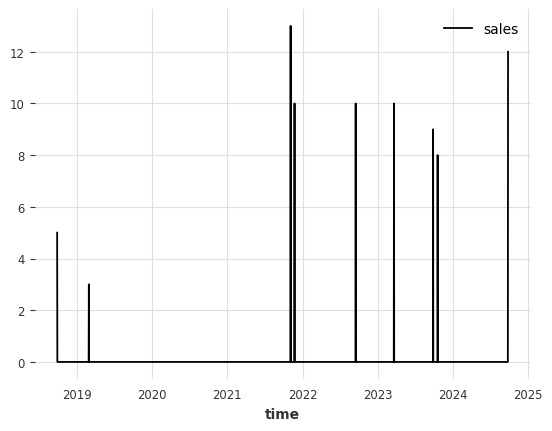

In [48]:
ax1 = sns.lineplot(data=intermittent_df[intermittent_df.item == 1061].set_index('time')[['sales']])

## Demanda suavizada

Ítems que no tienen periodos de ventas nulas. Hemos visto que estos ítems son prácticamente repuestos que se vendieron una sola vez, por lo que no vale la pena considerarlos dentro de nuestro análisis

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


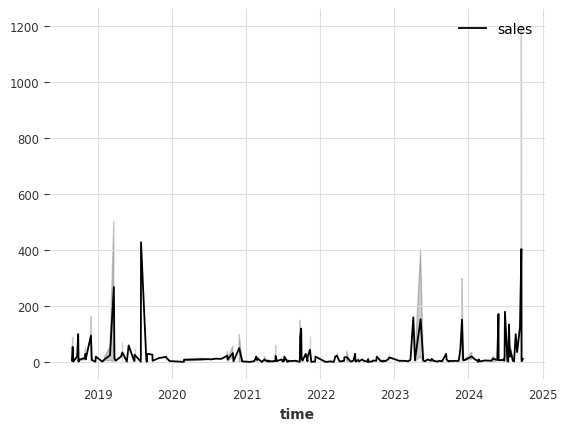

In [49]:
ax2 = sns.lineplot(data=smooth_df.set_index('time')[['sales']])

## Demanda grumosa

Filtramos por el ítem `5432`. Son aquellos ítems que tienen una venta con una cierta periodicidad (no teniendo ventas en todos los periodos, pero regularmente)

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


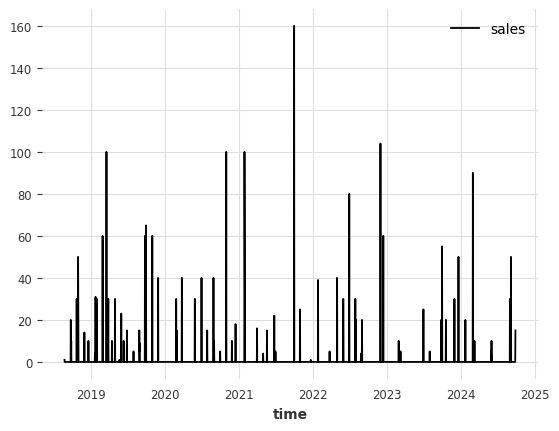

In [51]:
ax1 = sns.lineplot(data=lumpy_df[lumpy_df.item == 5432].set_index('time')[['sales']])